<a href="https://colab.research.google.com/github/CCMunozB/Patrones/blob/main/9_domain_specific_nlp_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

Preparamos el ambiente de trabajo de Google Colab

In [1]:
!wget https://zenodo.org/record/3924799/files/cwlce.vec # Descargamos los embedding clínicos calculados por PLN@CMM

--2023-06-13 16:01:29--  https://zenodo.org/record/3924799/files/cwlce.vec
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163303193 (156M) [application/octet-stream]
Saving to: ‘cwlce.vec’

cwlce.vec           100%[===================>] 155.74M  1.84MB/s    in 2m 12s  

2023-06-13 16:03:44 (1.18 MB/s) - ‘cwlce.vec’ saved [163303193/163303193]



In [2]:
!wget https://users.dcc.uchile.cl/~fvillena/files/cwlce_vocab.txt # Descargamos el vocabulario del texto

--2023-06-13 16:03:44--  https://users.dcc.uchile.cl/~fvillena/files/cwlce_vocab.txt
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574476 (561K) [text/plain]
Saving to: ‘cwlce_vocab.txt’

cwlce_vocab.txt     100%[===================>] 561.01K   412KB/s    in 1.4s    

2023-06-13 16:03:47 (412 KB/s) - ‘cwlce_vocab.txt’ saved [574476/574476]



In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.5 MB/s eta 0:00:00


In [4]:
import tensorflow as tf # Biblioteca de deep learning
import gensim # Biblioteca de modelamiento de lenguaje
import datasets # Biblioteca de manejo de conjuntos de datos para procesamiento de lenguaje natural
import numpy as np # Biblioteca de manejo de datos vectoriales
import matplotlib.pyplot as plt # Biblioteca de visualización

Cargamos el conjunto de datos del curso.

In [5]:
spanish_diagnostics = datasets.load_dataset('fvillena/spanish_diagnostics') # Cargamos las particiones de entrenamiento y prueba

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset spanish_diagnostics downloaded and prepared to /root/.cache/huggingface/datasets/fvillena___spanish_diagnostics/default/0.0.0/45c176cea64580ea9631f78c2867a657ede368597681e5337e9f1c976e4e84ff. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Preprocesamiento

In [6]:
import re
def normalize(text, remove_tildes = True):
    """Normaliza una cadena de texto convirtiéndo todo a minúsculas, quitando los caracteres no alfabéticos y los tildes"""
    text = text.lower() # Llevamos todo a minúscula
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text) # Reemplazamos los caracteres no alfabéticos por un espacio
    if remove_tildes:
        text = re.sub('á', 'a', text) # Reemplazamos los tildes
        text = re.sub('é', 'e', text)
        text = re.sub('í', 'i', text)
        text = re.sub('ó', 'o', text)
        text = re.sub('ú', 'u', text)
    return text

Normalizamos el corpus.

In [7]:
spanish_diagnostics_normalized = spanish_diagnostics.map(
    lambda x: {
        "normalized_text" : normalize(x["text"])
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Para poder pasar nuestros documentos por la red neuronal, cada uno debe ser convertido a una secuencia de índices de palabras del vocabulario. Además, debemos asegurarnos que cada una de las secuencias que utilizaremos para entrenar el modelo tiene el mismo largo.

Primero tokenizamos el texto crudo.

In [8]:
document = spanish_diagnostics_normalized["train"]["normalized_text"][0]
document

'  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar'

In [9]:
tokens = tf.keras.preprocessing.text.text_to_word_sequence(document)
tokens

['anomalias',
 'dentofaciales',
 'incluso',
 'la',
 'maloclusion',
 'discrepancia',
 'dentomaxilar']

Convertimos esta lista de tokens en una lista de índices de palabras respecto al vocabulario, sólo si esta palabra está en el vocabulario.

In [10]:
vocab = []
with open("cwlce_vocab.txt", 'r', encoding="utf-8") as f:
  for line in f:
    vocab.append(line.strip())
sequence = [vocab.index(word) for word in tokens if word in vocab]
sequence

[76, 123, 131, 3, 83, 2552, 737]

Finalmente agregamos ceros al principio de nuestra secuencia para que todas tengan exactamente el mismo largo.

In [11]:
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=20)
padded_sequence

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   76,  123,  131,    3,   83, 2552,  737]],
      dtype=int32)

Consolidamos todo en una función.

In [12]:
def text_to_sequence(text,vocab):
  """Esta función recibe una lista de strings y devuelve una lista de listas de índices del vocabulario"""
  sequences = []
  tokens = tf.keras.preprocessing.text.text_to_word_sequence(text)
  sequence = [vocab.index(word) for word in tokens if word in vocab]
  sequences.append(sequence)
  return sequences

In [13]:
def encode_text(text,vocab,maxlen=20):
  """Esta función recibe string y devuelve una lista de índices del vocabulario con padding"""
  sequences = text_to_sequence(text,vocab)
  padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)
  return padded_sequences[0]

Verificamos cómo funciona nuestra función.

In [14]:
encode_text("cancer    de colon",vocab)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 192,   1, 235], dtype=int32)

Aplicamos nuestra función a todo el corpus.

In [15]:
spanish_diagnostics_normalized_encoded = spanish_diagnostics_normalized.map(
    lambda x: {
        "encoded_text" : encode_text(x["normalized_text"],vocab)
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Así se ve una instancia de nuestro dataset.

In [16]:
spanish_diagnostics_normalized_encoded["train"][0]

{'text': '- ANOMALÍAS DENTOFACIALES (INCLUSO LA MALOCLUSIÓN)\n\n\n DISCREPANCIA DENTOMAXILAR',
 'label': 1,
 'normalized_text': '  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar',
 'encoded_text': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  76,
  123,
  131,
  3,
  83,
  2552,
  737]}

## Modelamiento

El primer paso del modelamiento es declarar la arquitectura que tendrá nuestra red neuronal. El tipo de red neuronal más utilizado para resolver tareas relacionadas con textos son las redes neuronales recurrentes.

En este caso diseñaremos una red neuronal recurrente simple en donde cada una de las celdas de la red neuronal toma como entrada la salida del paso anterior en la secuencia.

La primera capa de nuestra arquitectura será la representación de cada una de las palabras del corpus a través de un embedding. Esta capa representará la secuencia de índices como una secuencia de embeddings asociados a cada palabra del vocabulario.

Esta secuencia de embeddings se pasará de manera serial por la capa recurrente simple y el estado oculto asociado al último paso de la secuencia será la representación asociada a la secuencia completa.

Esta representación de la secuencia entrará a la última capa densa que contiene sólo una neurona que representará la salida verdadera o falsa de nuestra red.

Especificamente en esta instancia compararemos los rendimientos de esta arquitectura al inicializar la capa de embedding con valores al azar y al inicializar la capa de embedding con valores preentrenados. También cada modelo tendrá una versión en donde sí estamos ajustando los embedding y donde no estamos ajustando los embedding.

In [17]:
def make_model(embedding,trainable_embeddings,vocab):
  """Con esta función instanciamos la arquitectura de red neuronal recurrente."""
  model = tf.keras.Sequential() # La declaración de la arquitectura se hará de manera secuencial. La salida de la capa será la entrada de la capa siguiente.
  if embedding == "random": # La capa de embedding estará condicionada con esto.
    embedding_layer = tf.keras.layers.Embedding( # Esta capa de embedding se inicializará con valores al azar.
        input_dim=len(vocab), # La cantidad de embeddings (filas) será igual al tamaño del vocabulario.
        output_dim=300, # Cada palabra se representará con 300 dimensiones-
        trainable=trainable_embeddings, # Con esto declaramos si se ajustará o no la capa de embedding.
        mask_zero=True # Con esto omitimos pasar a la siguiente capa la representación del padding.
    )
  else:
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=len(vocab),
        output_dim=embedding.vectors.shape[1],
        trainable=trainable_embeddings,
        weights=[embedding.vectors], # Inicializamos la capa de embedding con los embedding preentrenados.
        mask_zero=True
    )
  model.add(embedding_layer) # Agregamos la capa de embedding a la arquitectura
  model.add(tf.keras.layers.SimpleRNN( # Agregamos la capa recurrente a la arquitectura
      128, # La salida de esta capa tendrá 128 dimensiones
      recurrent_dropout=0.2)) # Al azar cambia por 0 el 30 % de los pesos con el fin de disminuir el sobreajuste.
  model.add(tf.keras.layers.Dropout(0.3)) # Esta capa al azar cambia por 0 el 30 % de los pesos con el fin de disminuir el sobreajuste.
  model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # Esta es la capa de clasificación binaria.
  model.compile( # Compilamos el modelo
      loss='binary_crossentropy', # Utilizamos entropia cruzada binaria debido a la que la capa de clasificación es binaria
      optimizer='adam', # Usamos ADAM como optimización, un descenso de gradientes "inteligente".
      metrics=['accuracy']) # Medimos el rendimiento de la clasificación con accuracy debido a que nuestras clases están balanceadas.
  return model

In [18]:
spanish_diagnostics_normalized_encoded.set_format(type="numpy", columns=["encoded_text","label"]) # transformamos las características a arreglos de numpy

### Entrenamiento

Entrenaremos 4 modelos distintos y compararemos sus resultados:

1.   Modelo utilizando embeddings preentrenados y además ajustándolos en el entrenamiento.
2.   Modelo utilizando embeddings preentrenados y sin ajustarlos en el entrenamiento.
3.   Modelo sin utilizar embeddings preentrenados, sólo ajustándolos en el entrenamiento.
4.   Modelo sin utilizar embeddings preentrenados y sin ajustarlos en el entrenamiento.

In [20]:
cwlce = gensim.models.KeyedVectors.load_word2vec_format("cwlce.vec")

#### Embeddings clínicos preentrenados con ajuste en el entrenamiento.

Utilizaremos los embeddings preentrenados en un corpus clínico y además los ajustaremos para resolver la tarea de clasificación

In [21]:
model_cwlce_trainable = make_model( # Instanciamos nuestro modelo
    embedding = cwlce, # Usamos los embeddings preentrenados
    trainable_embeddings = True, # Ajustamos los modelos en el entrenamiento
    vocab = vocab # Usamos el vocabulario de los embeddings
)
model_cwlce_trainable_hist = model_cwlce_trainable.fit( # Ajustamos el modelo
    spanish_diagnostics_normalized_encoded["train"]["encoded_text"][:7000], # Utilizamos el 10% de los datos de entrenamiento
    spanish_diagnostics_normalized_encoded["train"]["label"][:7000],
    epochs=10, # Entrenamos máximo por 10 épocas
    validation_data=( # Utilizamos el conjunto de prueba para validar el modelo al final de cada época.
        spanish_diagnostics_normalized_encoded["test"]["encoded_text"][:3000],
        spanish_diagnostics_normalized_encoded["test"]["label"][:3000],
    )
)

Epoch 1/10
219/219 [==============================] - 35s 133ms/step - loss: 0.2015 - accuracy: 0.9374 - val_loss: 0.1426 - val_accuracy: 0.9587
Epoch 2/10
219/219 [==============================] - 13s 61ms/step - loss: 0.1389 - accuracy: 0.9600 - val_loss: 0.1377 - val_accuracy: 0.9593
Epoch 3/10
219/219 [==============================] - 13s 57ms/step - loss: 0.1056 - accuracy: 0.9683 - val_loss: 0.1456 - val_accuracy: 0.9557
Epoch 4/10
219/219 [==============================] - 11s 52ms/step - loss: 0.0750 - accuracy: 0.9771 - val_loss: 0.1684 - val_accuracy: 0.9560
Epoch 5/10
219/219 [==============================] - 13s 59ms/step - loss: 0.0583 - accuracy: 0.9803 - val_loss: 0.1863 - val_accuracy: 0.9427
Epoch 6/10
219/219 [==============================] - 12s 53ms/step - loss: 0.0477 - accuracy: 0.9846 - val_loss: 0.1895 - val_accuracy: 0.9480
Epoch 7/10
219/219 [==============================] - 11s 52ms/step - loss: 0.0374 - accuracy: 0.9876 - val_loss: 0.2190 - val_accuracy

#### Embeddings clínicos preentrenados sin ajuste en el entrenamiento.

Utilizaremos los embeddings preentrenados en un corpus clínico y no los ajustaremos al resolver la tarea de clasificación.

In [22]:
model_cwlce_frozen = make_model(
    embedding = cwlce,
    trainable_embeddings = False, # No ajustamos los modelos en el entrenamiento
    vocab = vocab
)
model_cwlce_frozen_hist = model_cwlce_frozen.fit(
    spanish_diagnostics_normalized_encoded["train"]["encoded_text"][:7000],
    spanish_diagnostics_normalized_encoded["train"]["label"][:7000],
    epochs=10,
    validation_data=(
        spanish_diagnostics_normalized_encoded["test"]["encoded_text"][:3000],
        spanish_diagnostics_normalized_encoded["test"]["label"][:3000],
    )
)

Epoch 1/10
219/219 [==============================] - 11s 40ms/step - loss: 0.2265 - accuracy: 0.9240 - val_loss: 0.1389 - val_accuracy: 0.9583
Epoch 2/10
219/219 [==============================] - 10s 44ms/step - loss: 0.1628 - accuracy: 0.9547 - val_loss: 0.1454 - val_accuracy: 0.9573
Epoch 3/10
219/219 [==============================] - 10s 44ms/step - loss: 0.1483 - accuracy: 0.9549 - val_loss: 0.1324 - val_accuracy: 0.9607
Epoch 4/10
219/219 [==============================] - 9s 43ms/step - loss: 0.1410 - accuracy: 0.9599 - val_loss: 0.1375 - val_accuracy: 0.9567
Epoch 5/10
219/219 [==============================] - 10s 44ms/step - loss: 0.1296 - accuracy: 0.9616 - val_loss: 0.1418 - val_accuracy: 0.9593
Epoch 6/10
219/219 [==============================] - 10s 44ms/step - loss: 0.1204 - accuracy: 0.9640 - val_loss: 0.1514 - val_accuracy: 0.9570
Epoch 7/10
219/219 [==============================] - 10s 46ms/step - loss: 0.1167 - accuracy: 0.9647 - val_loss: 0.1538 - val_accuracy: 

#### Los embeddings se ajustan en el entrenamiento

No utilizaremos los embeddings preentrenados, los ajustaremos mientras se resuelve la tarea de clasificación

In [23]:
model_random_trainable = make_model(
    embedding = "random", # No usamos embeddings preentrenados.
    trainable_embeddings = True,
    vocab = vocab
)
model_random_trainable_hist = model_random_trainable.fit(
    spanish_diagnostics_normalized_encoded["train"]["encoded_text"][:7000],
    spanish_diagnostics_normalized_encoded["train"]["label"][:7000],
    epochs=10,
    validation_data=(
        spanish_diagnostics_normalized_encoded["test"]["encoded_text"][:3000],
        spanish_diagnostics_normalized_encoded["test"]["label"][:3000],
    )
)

Epoch 1/10
219/219 [==============================] - 26s 109ms/step - loss: 0.3331 - accuracy: 0.8686 - val_loss: 0.1929 - val_accuracy: 0.9437
Epoch 2/10
219/219 [==============================] - 14s 64ms/step - loss: 0.1230 - accuracy: 0.9654 - val_loss: 0.1718 - val_accuracy: 0.9427
Epoch 3/10
219/219 [==============================] - 12s 57ms/step - loss: 0.0728 - accuracy: 0.9807 - val_loss: 0.1890 - val_accuracy: 0.9353
Epoch 4/10
219/219 [==============================] - 12s 56ms/step - loss: 0.0544 - accuracy: 0.9840 - val_loss: 0.2139 - val_accuracy: 0.9277
Epoch 5/10
219/219 [==============================] - 12s 54ms/step - loss: 0.0395 - accuracy: 0.9889 - val_loss: 0.2512 - val_accuracy: 0.9350
Epoch 6/10
219/219 [==============================] - 11s 50ms/step - loss: 0.0390 - accuracy: 0.9880 - val_loss: 0.2397 - val_accuracy: 0.9247
Epoch 7/10
219/219 [==============================] - 11s 51ms/step - loss: 0.0318 - accuracy: 0.9886 - val_loss: 0.2598 - val_accuracy

#### Los embeddings no se ajustan en el entrenamiento ni se preentrenan

No utilizaremos los embeddings preentrenados ni los ajustaremos mientras se resuelve la tarea de clasificación

In [24]:
model_random_frozen = make_model(
    embedding = "random",
    trainable_embeddings = False,
    vocab = vocab
)
model_random_frozen_hist = model_random_frozen.fit(
    spanish_diagnostics_normalized_encoded["train"]["encoded_text"][:7000],
    spanish_diagnostics_normalized_encoded["train"]["label"][:7000],
    epochs=10,
    validation_data=(
        spanish_diagnostics_normalized_encoded["test"]["encoded_text"][:3000],
        spanish_diagnostics_normalized_encoded["test"]["label"][:3000],
    )
)

Epoch 1/10
219/219 [==============================] - 12s 45ms/step - loss: 0.5698 - accuracy: 0.7410 - val_loss: 0.4923 - val_accuracy: 0.8037
Epoch 2/10
219/219 [==============================] - 9s 43ms/step - loss: 0.4723 - accuracy: 0.8173 - val_loss: 0.4165 - val_accuracy: 0.8340
Epoch 3/10
219/219 [==============================] - 8s 39ms/step - loss: 0.4214 - accuracy: 0.8396 - val_loss: 0.4624 - val_accuracy: 0.8213
Epoch 4/10
219/219 [==============================] - 9s 41ms/step - loss: 0.3960 - accuracy: 0.8470 - val_loss: 0.3969 - val_accuracy: 0.8400
Epoch 5/10
219/219 [==============================] - 9s 42ms/step - loss: 0.3820 - accuracy: 0.8514 - val_loss: 0.4133 - val_accuracy: 0.8443
Epoch 6/10
219/219 [==============================] - 10s 44ms/step - loss: 0.3804 - accuracy: 0.8460 - val_loss: 0.3669 - val_accuracy: 0.8553
Epoch 7/10
219/219 [==============================] - 8s 36ms/step - loss: 0.3651 - accuracy: 0.8540 - val_loss: 0.3488 - val_accuracy: 0.85

### Comparación

Compararemos cómo se van comportando las métricas objetivo a medida que avanzaron las épocas.

Los modelos que usaron embeddings preentrenados obtuvieron el mejor rendimiento y al ajustar esos embeddings preentrenados obtenemos un mejor rendimiento.

El ajustar los embeddings sin preentrenarlos también genera buenos resultados, pero el nunca ajustar los embeddings genera muy malos resultados porque no tenemos un modelo lo suficientemente flexible para ajustarse a resolver la tarea.

Se debe destacar que el no ajustar los embeddings en el entrenamiento genera un aumento significativo en la velocidad de entrenamiento.

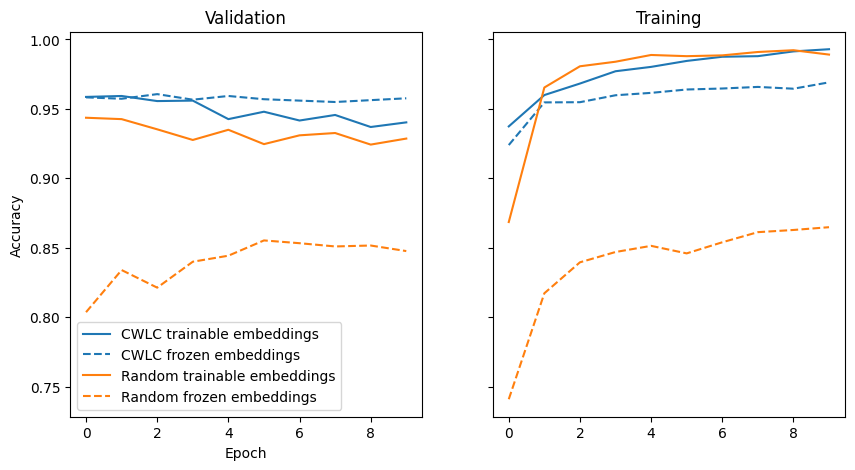

In [25]:
fig, axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)

axs[0].plot(
    model_cwlce_trainable_hist.history["val_accuracy"],
    c="tab:blue",
    label="CWLC trainable embeddings"
)
axs[0].plot(
    model_cwlce_frozen_hist.history["val_accuracy"],
    c="tab:blue",
    linestyle="--",
    label="CWLC frozen embeddings"
)

axs[0].plot(
    model_random_trainable_hist.history["val_accuracy"],
    c="tab:orange",
    label="Random trainable embeddings"
)
axs[0].plot(
    model_random_frozen_hist.history["val_accuracy"],
    c="tab:orange",
    linestyle="--",
    label="Random frozen embeddings"
)


axs[1].plot(
    model_cwlce_trainable_hist.history["accuracy"],
    c="tab:blue",
    label="CWLC trainable embeddings"
)
axs[1].plot(
    model_cwlce_frozen_hist.history["accuracy"],
    c="tab:blue",
    linestyle="--",
    label="CWLC frozen embeddings"
)

axs[1].plot(
    model_random_trainable_hist.history["accuracy"],
    c="tab:orange",
    label="Random trainable embeddings"
)
axs[1].plot(
    model_random_frozen_hist.history["accuracy"],
    c="tab:orange",
    linestyle="--",
    label="Random frozen embeddings"
)
axs[0].legend()
axs[0].set_title("Validation")
axs[1].set_title("Training")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
plt.show()